In [58]:
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

## 1. Load Institutes

In [49]:
def load_ipeds_unis(fname='../data/IPEDS/hd2020.csv', encoding='cp1252'):
    return pd.read_csv(fname, encoding=encoding)

def filter_only_rs_and_las(unis):
    unis = unis[unis['C18BASIC'].apply(lambda x: x in [15, 16, 17, 21, 22])]
    unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')
    return unis

def preprocess_names(unis):
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
    unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
    unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
    return unis

def fetch_rankings(fname='../data/US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5,\
                   usecols=['Institution Name', 'Full Time Enrollment', 'Ranking List', 'Rank'], top=-1):
    
    rankings = pd.read_excel(fname,skiprows=skiprows, usecols=usecols)
    
    if top > -1:
        rankings = rankings[rankings['Rank']<=top]
        
    return rankings

In [50]:
unis     = load_ipeds_unis()
unis     = filter_only_rs_and_las(unis)
unis     = preprocess_names(unis)

rankings = fetch_rankings(top=100)

merged   = pd.merge(unis, rankings, left_on='INSTNM', right_on='Institution Name')

print("Missing unis: %s " % set(rankings['Institution Name']).difference(merged['INSTNM']))

/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_18132/1318604980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')


Missing unis: set() 


In [51]:
insts = merged[['UNITID', 'INSTNM', 'Y', 'HBCU']]

## 2. Load completions data

In [239]:
women = ("women", "CTOTALW", "CRACE16")
black = ("black", "CBKAAT", "CRACE18")
hispanic = ("hispanic", "CHISPT", "CRACE21")
natives = ("natives", "CAIANT", "CRACE19")

results = {}

fnames = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')

for i, fname in enumerate(fnames):
    print("%s/%s - %s" % (i, len(fnames), fname))
    year = int(fname.split('/')[-1].split('_')[0][1:])
    if year in [2000, 2001]:
        continue

    data = pd.read_csv(fname, index_col=0)
    data.columns = [col.upper() for col in data.columns]
    data = data[data['AWLEVEL']==5]
    cs = data[data['CIPCODE']==11.0701]
    #cs = data[data['CIPCODE'].apply(lambda x: (x>=11) & (x<12))]
    cs.columns = [col.strip() for col in cs.columns]
    cs = cs.groupby(cs.index).sum()
    cs_cols = list(cs.columns)
    year_result = pd.DataFrame()
    for (label, var, var_alt) in [women, black, hispanic, natives]:
        if var in cs_cols:
            year_result["%s_%s" % (label, year)] = cs[var]#/cs['CTOTALT']
        elif 'CRACE24' in cs_cols:
            #print("With CRACE26 - %s" % fname)
            year_result["%s_%s" % (label, year)] = cs[var_alt]#/cs['CRACE24']
        else:
            #print("Without CRACE24 - %s" % fname)
            year_result["%s_%s" % (label, year)] = cs[var_alt]#/(cs['CRACE15']+cs['CRACE16'])

    results[year] = year_result

0/21 - ../data/IPEDS/C2009_A/c2009_a_rv.csv
1/21 - ../data/IPEDS/C2007_A/c2007_a_rv.csv
2/21 - ../data/IPEDS/C2017_A/c2017_a_rv.csv
3/21 - ../data/IPEDS/C2013_A/c2013_a_rv.csv
4/21 - ../data/IPEDS/C2019_A/c2019_a_rv.csv
5/21 - ../data/IPEDS/C2004_A/c2004_a_rv.csv
6/21 - ../data/IPEDS/C2014_A/c2014_a_rv.csv
7/21 - ../data/IPEDS/C2010_A/c2010_a_rv.csv
8/21 - ../data/IPEDS/C2005_A/c2005_a_rv.csv
9/21 - ../data/IPEDS/C2015_A/c2015_a_rv.csv
10/21 - ../data/IPEDS/C2011_A/c2011_a_rv.csv
11/21 - ../data/IPEDS/C2008_A/c2008_a_rv.csv
12/21 - ../data/IPEDS/C2006_A/c2006_a_rv.csv
13/21 - ../data/IPEDS/C2016_A/c2016_a_rv.csv
14/21 - ../data/IPEDS/C2018_A/c2018_a_rv.csv
15/21 - ../data/IPEDS/C2012_A/c2012_a_rv.csv


/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_18132/3223581062.py:16: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(fname, index_col=0)


16/21 - ../data/IPEDS/c2000_a.csv
17/21 - ../data/IPEDS/c2002_a.csv
18/21 - ../data/IPEDS/c2020_a.csv
19/21 - ../data/IPEDS/c2003_a.csv
20/21 - ../data/IPEDS/c2001_a.csv


## 2.1. Institutes that have data for all years

In [241]:
years = list(results.keys())
commonids = set(results[years[0]].index)
for year in years[1:]:
    commonids = commonids.intersection(set(results[year].index))
    
all_years = pd.concat([results[year].loc[commonids] for year in years], axis=1)
merged = pd.merge(insts, all_years, left_on='UNITID', right_index=True)

/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_18132/3210668323.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  all_years = pd.concat([results[year].loc[commonids] for year in years], axis=1)
/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_18132/3210668323.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  all_years = pd.concat([results[year].loc[commonids] for year in years], axis=1)
/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_18132/3210668323.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  all_years = pd.concat([results[year].loc[commonids] for year in years], axis=1)
/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_18132/3210668323.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future ver

In [166]:
wcompletions           = merged[[col for col in merged.columns if 'women' in col]]

years                  = [int(col.split('_')[1]) for col in wcompletions.columns]

wcompletions.columns   = years
wcompletions.index     = merged['UNITID']
# wcompletions['INSTNM'] = merged['INSTNM']
# wcompletions['Y']      = merged['Y']

wcompletions_flat = pd.DataFrame(pd.concat(wcompletions[col] for col in wcompletions.columns), columns=['wcompletions'])
wcompletions_flat['grad_year'] = [year for year in wcompletions.columns for idx in wcompletions.index]

## 3. Load admissions data

In [167]:
fnames = glob('../data/admissions/*/*_rv.csv')+['../data/admissions/adm2020.csv']

all_data = []
for fname in fnames:
    year = int(fname.split('/')[-1].split('_')[0].replace('.csv', '')[-4:])
    data = pd.read_csv(fname, index_col=0, usecols=['UNITID', 'ADMSSNW'])
    data = data.rename(columns={'ADMSSNW':year})
    all_data.append(data)

wadmissions = pd.concat(all_data, axis=1)

wadmissions_flat = pd.DataFrame(pd.concat([wadmissions[col] for col in wadmissions.columns]), columns=['admissions'])
wadmissions_flat['admit_year'] = [year for year in wadmissions.columns for idx in wadmissions.index]
wadmissions_flat['admit_year+4'] = wadmissions_flat['admit_year']+4

In [168]:
adm_vs_grad = pd.merge(wadmissions_flat, wcompletions_flat, on='UNITID')

In [198]:
adm_vs_grad = adm_vs_grad[adm_vs_grad['admit_year+4']==adm_vs_grad['grad_year']]

In [199]:
adm_vs_grad['ratio'] = 100*(adm_vs_grad['wcompletions']/adm_vs_grad['admissions'])

/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_18132/924093328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm_vs_grad['ratio'] = 100*(adm_vs_grad['wcompletions']/adm_vs_grad['admissions'])


In [200]:
merged = pd.merge(adm_vs_grad, insts, left_index=True, right_on='UNITID')

In [201]:
la = merged[merged['Y']=='liberal_arts']
toplot_la = la.groupby('grad_year').apply(lambda x: pd.Series({'mean':x['ratio'].mean(), 'sem':x['ratio'].sem()}))

rs = merged[merged['Y']=='research']
toplot_rs = rs.groupby('grad_year').apply(lambda x: pd.Series({'mean':x['ratio'].mean(), 'sem':x['ratio'].sem()}))

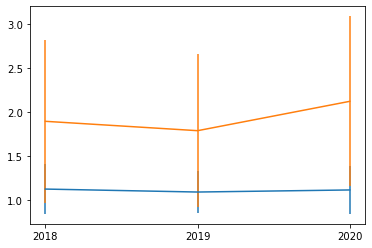

In [215]:
plt.errorbar(toplot_la.index, toplot_la['mean'], yerr=toplot_la['sem']);
plt.errorbar(toplot_rs.index, toplot_rs['mean'], yerr=toplot_rs['sem']);
plt.xticks([2018, 2019, 2020]);

In [230]:
adm_vs_grad

,admissions,admit_year,admit_year+4,wcompletions,grad_year,ratio
UNITID,,,,,,
115409,270.0,2016,2020,25,2020,9.259259
115409,262.0,2015,2019,20,2019,7.633588
115409,255.0,2014,2018,26,2018,10.196078
121345,379.0,2016,2020,7,2020,1.846966
121345,443.0,2015,2019,11,2019,2.483070
...,...,...,...,...,...,...
236948,10950.0,2015,2019,107,2019,0.977169
236948,9457.0,2014,2018,73,2018,0.771915
238333,1486.0,2016,2020,4,2020,0.269179


In [238]:
wcompletions.loc[218070]

KeyError: 218070

In [236]:
wadmissions_flat.loc[218070]

,admissions,admit_year,admit_year+4
UNITID,,,
218070,2096.0,2018,2022
218070,2232.0,2016,2020
218070,1907.0,2017,2021
218070,1844.0,2019,2023
218070,1982.0,2015,2019
218070,1939.0,2014,2018
218070,2037.0,2020,2024
